<a href="https://colab.research.google.com/github/muskan2103/tweet-classification-nlp/blob/main/nlp_using_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from textblob import TextBlob
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer
tb = Blobber(analyzer=NaiveBayesAnalyzer())

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
words = set(nltk.corpus.words.words())
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, metrics, preprocessing, ensemble

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
raw_data = pd.read_csv('/content/train.csv')
raw_data.shape
raw_data.info
raw_data.head()
raw_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
print(raw_data['target'].value_counts()[1])
print(raw_data['target'].value_counts()[0])

3271
4342


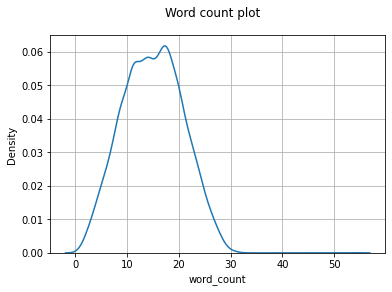

In [ ]:
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split(" ")) )
sns.kdeplot(raw_data['word_count'])
plt.grid()
plt.suptitle("Word count plot")
plt.show()

In [ ]:
#REMOVE WRONGLY REPEATED LETTERS EXAMPLE: 'AWWWWWESOMEE'
def fix_length(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

#REMOVE URL,NUMBERS,NON-ALPHANUMERIC CHARACTERS AND PUNCTUATIONS.
#CHANGE WORDS TO PRESENT TENSE, PLURALS TO SINGULARS AND LEMMATIZE THE TWEETS.
def clean_text(each_text):
     each_text_no_url = re.sub(r"http\S+", "", each_text)
     text_no_num = re.sub(r'\d+', '', each_text_no_url)
     word_tokens = word_tokenize(text_no_num)
     corrected_text=[]
     for word in word_tokens:
          word_1="".join([e.lower() for e in word if e.isalnum()])
          word_2=fix_length(word_1)
          corrected_text.append(str(tb(word_2)))
     lemmatizer = nltk.stem.WordNetLemmatizer()
     lemmatized_text = [lemmatizer.lemmatize(w,'v') for w in corrected_text]
     lemmatized_text_2 = [lemmatizer.lemmatize(w) for w in lemmatized_text]
     return " ".join(lemmatized_text_2)

raw_data['cleaned_text']=raw_data['text'].apply(lambda x:clean_text(x))
print(raw_data['cleaned_text'])
raw_data['keyword']=raw_data['keyword'].fillna("none")
raw_data['cleaned_keyword']=raw_data['keyword'].apply(lambda x:clean_text(x))
raw_data['cleaned_keyword'].unique()



0       our deed be the reason of this  earthquake may...
1                  forest fire near la ronge sask  canada
2       all resident ask to shelter in place  be be no...
3        people receive  wildfire evacuation order in ...
4       just get send this photo from ruby  alaska a s...
                              ...                        
7608    two giant crane hold a bridge collapse into ne...
7609     ariaahrary  thetawniest the out of control wi...
7610                    m   utc   km s of volcano hawaii 
7611    police investigate after an ebike collide with...
7612    the latest  more home raze by northern califor...
Name: cleaned_text, Length: 7613, dtype: object


array(['none', 'ablaze', 'accident', 'aftershock', 'airplane  accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleed',
       'blow  up', 'blight', 'blizzard', 'blood', 'bloody', 'body  bag',
       'bomb', 'bridge  collapse', 'build  burn', 'build  on  fire',
       'burn', 'burn  build', 'bush  fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical  emergency', 'cliff  fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust  storm', 'earthquake', 'electrocute', 'emergency',
       'emergency  pl

In [ ]:
#REMOVE ALL NON-ENGLISH WORDS
def remove_non_english_words(each_text,Array):
     word_tokens=word_tokenize(each_text)
     clean_text_2=[w for w in word_tokens if w in words or w in Array]
     return " ".join(clean_text_2)
     
Array=raw_data['cleaned_keyword'].unique()
raw_data['cleaned_text_2']=raw_data['cleaned_text'].apply(lambda x:remove_non_english_words(x,Array))
raw_data['cleaned_text_2']

0       our deed be the reason of this earthquake may ...
1                              forest fire near la canada
2       all resident ask to shelter in place be be not...
3             people receive wildfire evacuation order in
4       just get send this photo from ruby a smoke fro...
                              ...                        
7608    two giant crane hold a bridge collapse into ne...
7609    the out of control wild fire in even in the no...
7610                                       m s of volcano
7611    police investigate after an collide with a car...
7612    the latest more home raze by northern wildfire...
Name: cleaned_text_2, Length: 7613, dtype: object

In [ ]:
stop_words = set(stopwords.words('english'))

#REMOVE STOPWORDS FROM TWEETS
def remove_stopwords(each_text):
     word_tokens = word_tokenize(each_text)
     text_with_no_stop_word = [w.lower() for w in word_tokens if not w in stop_words]
     return " ".join(text_with_no_stop_word)

raw_data['modified_text']=raw_data['cleaned_text_2'].apply(lambda x:remove_stopwords(x))
raw_data['modified_text']

0                    deed reason earthquake may forgive u
1                              forest fire near la canada
2       resident ask shelter place notify officer evac...
3                people receive wildfire evacuation order
4          get send photo ruby smoke wildfire pour school
                              ...                        
7608     two giant crane hold bridge collapse nearby home
7609    control wild fire even northern part state tro...
7610                                              volcano
7611    police investigate collide car little rider su...
7612              latest home raze northern wildfire news
Name: modified_text, Length: 7613, dtype: object

In [ ]:
raw_data['keyword_text'] = raw_data['cleaned_keyword']+" "+raw_data['modified_text']
raw_data['keyword_text']=raw_data['keyword_text'].apply(lambda x: x.replace('none', ''))

In [ ]:
#CLEANED ARRAY OF WORDS
for i in raw_data['keyword_text']:
  print(word_tokenize(i))

Streaming output truncated to the last 5000 lines.
['destruction', 'help', 'save', 'beautiful', 'town', 'destruction', 'power', 'plant', 'developer']
['destruction', 'crackdown', 'destruction', 'restrict', 'crackdown', 'impress', 'week']
['destruction', 'greed', 'fuel']
['destruction', 'contrast', 'forebode', 'destruction', 'enhance', 'expansive', 'division', 'color', 'saturation', 'contrast', 'hue']
['destruction', 'authority', 'take', 'account', 'petition', 'destruction', 'sanction', 'food', 'press']
['destruction', 'fall', 'back', 'first', 'break', 'miscalculation', 'could', 'destruction', 'thousand']
['destruction', 'fly', 'loose', 'two', 'bore', 'cat', 'terrible', 'thing', 'destruction']
['destruction', 'many', 'spec', 'much', 'fan', 'service', 'much', 'lore', 'destruction']
['destruction', 'truck', 'driver', 'salvage', 'ban', 'tomato', 'destruction', 'border', 'news']
['destruction', 'republican', 'style', 'economic', 'destruction']
['destruction', 'cause', 'self', 'destruction']

In [ ]:
feature = 'keyword_text'
label = "target"

x = raw_data.loc[:, ['keyword_text']]
y = raw_data.loc[:, ['target']]
X_train, X_test,y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0,shuffle=True)#SPLITTING DATASET INTO TRAIN AND TEST

In [ ]:
X_train_RFC = X_train.values.reshape(-1)
x_test_RFC = X_test.values.reshape(-1)

In [ ]:
vectorizer = CountVectorizer()
X_train_RFC = vectorizer.fit_transform(X_train_RFC)
print(vectorizer.get_feature_names_out())#FEATURES

x_test_RFC = vectorizer.transform(x_test_RFC)

['aa' 'aal' 'aba' ... 'zombie' 'zone' 'zoom']


In [ ]:
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression()
model.fit(X_train_RFC, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
predicted_prob = model.predict_proba(x_test_RFC)[:,1]
predicted = model.predict(x_test_RFC)

accuracy = metrics.accuracy_score(predicted, y_test)*100
print("Test accuracy:%.2f"%accuracy,"%")

Test accuracy:80.69 %


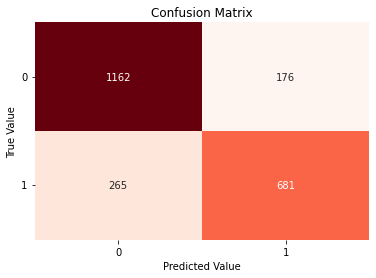

In [ ]:
conf_matrix = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()